In [1]:
import numpy as np
import scipy as sp
import math
from scipy.ndimage import interpolation
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix

from time import time

# **1. Load Raw Data**

In [2]:
#download the 4 .gz data files, uncompress and put in folder data/

def read_data(imgf, labelf, outf, n):
    f = open(imgf, "rb")
    l = open(labelf, "rb")

    f.read(16)
    l.read(8)
    images = []

    for i in range(n):
        image = [ord(l.read(1))]
        for j in range(28*28):
            image.append(ord(f.read(1)))
        images.append(image)

    f.close()
    l.close()
    df = pd.DataFrame(images)
    df.rename(columns = {0:'label'}, inplace = True) 
    return df

data_train = read_data("train-images.idx3-ubyte", "train-labels.idx1-ubyte",
        "mnist_train.csv", 60000)
data_test = read_data("t10k-images.idx3-ubyte", "t10k-labels.idx1-ubyte",
        "mnist_test.csv", 10000)

In [3]:
X_train = data_train.drop(['label'], axis='columns', inplace=False)
Y_train = data_train['label']
X_test = data_test.drop(['label'], axis='columns', inplace=False)
Y_test = data_test['label']

# X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.25, 
#                                                     stratify=labels, random_state=30)

print ("train feature shape: ", X_train.shape)
print ("test feature shape: ", X_test.shape)

train feature shape:  (60000, 784)
test feature shape:  (10000, 784)


# **2. Deskew Raw Data**

In [383]:
def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix

def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    img = interpolation.affine_transform(image,affine,offset=offset)
    return (img - img.min()) / (img.max() - img.min())
    #return img

def deskew_vectorize(images):
    """Deskew matrix of N MNIST sample
    :images: Matrix size (N, 784)
    :returns: Matrix size (N, 28, 28)
    """
    N = images.shape[0]
    reshaped_images = images.reshape(N , 28, 28)
    deskewed_images = np.array(list(map(deskew, reshaped_images)))

    return deskewed_images.reshape(N, 784)

In [384]:
X_train_deskew = deskew_vectorize(X_train.values)
X_test_deskew = deskew_vectorize(X_test.values)
X_train_deskew_df = pd.DataFrame(X_train_deskew)
X_train_deskew_df.columns = X_train_deskew_df.columns+1
X_test_deskew_df = pd.DataFrame(X_test_deskew)
X_test_deskew_df.columns = X_test_deskew_df.columns+1

# **3. Enlarge Raw Data and Deskewed Data**

In [798]:
from skimage.transform import resize

def enlarge_figure(pixel_vector):
    X_array = pixel_vector.reshape((28,28))
    Threshold = sum(X_array[0])+ 250#255
    top = 0
    #Threshold = 28*min(X_array[up])
    Temp = sum(X_array[top])
    while Temp <= Threshold:
        top = top+1
        Temp = sum(X_array[top])
        
    bottom = 27
    #Threshold = 28*min(X_array[down])
    Temp = sum(X_array[bottom])
    while Temp <= Threshold:
        bottom = bottom-1
        Temp = sum(X_array[bottom])
        
    left = 0
    #Threshold = 28*min(X_array[:,left])
    Temp = sum(X_array[:,left])
    while Temp <= Threshold:
        left = left+1
        Temp = sum(X_array[:,left])
        
    right = 27
    #Threshold = 28*min(X_array[:,right])
    Temp = sum(X_array[:,right])
    while Temp <= Threshold:
        right = right-1
        Temp = sum(X_array[:,right])
        
    X_array = X_array[top:(bottom+1),left:(right+1)]
    #print(X_refine)
    X_array = resize(X_array, (28, 28),preserve_range=True,mode='constant')
    X_array = X_array.astype('uint8')
    #print(X_refine_resize)
    pixel_vector = X_array.reshape((1,784))
    #plot_Figure_Deskewed(pixel_vector)
    
    return pixel_vector

def enlarge_data(X_df,h,w=784):
    X_array = X_df.to_numpy(dtype='uint16')
    X_enlarge = X_array
    for i in range(h):
        X_enlarge[i] = enlarge_figure(X_array[i])
    X_enlarge = pd.DataFrame(X_enlarge)
    X_enlarge.columns = X_enlarge.columns+1
    return X_enlarge

In [554]:
t0 = time()
X_train_enlarge = enlarge_data(X_train,h=60000)
X_test_enlarge = enlarge_data(X_test,h=10000)
print("done in %0.3fs" % (time() - t0))

done in 67.518s


In [799]:
t0 = time()
X_train_deskew_enlarge = enlarge_data(X_train_deskew_df*255,h=60000)
X_test_deskew_enlarge = enlarge_data(X_test_deskew_df*255,h=10000)
print("done in %0.3fs" % (time() - t0))

done in 70.073s


# **4. Visualize Data**

In [285]:
def plot_number(label, pixels, w=28, h=28):
    #label = row['label']
    #pixels = row[1:]

    # Make those columns into a array of 8-bits pixels
    # This array will be of 1D with length 784
    # The pixel intensity values are integers from 0 to 255
    pixels = 255-np.array(pixels, dtype='uint8')

    # Reshape the array into 28 x 28 array (2-dimensional array)
    pixels = pixels.reshape((w, h))

    # Plot
    plt.title('Label is {label}'.format(label=label))
    plt.imshow(pixels, cmap='gray')


def plot_slice(label, pixels, size_w=28, size_h=28):
    num = pixels.shape[0]
    w = 4
    h = math.ceil(num / w)
    fig, plots = plt.subplots(h, w)
    fig.tight_layout()

    for n in range(0, num):
        s = plt.subplot(h, w, n+1)
        s.set_xticks(())
        s.set_yticks(())
        plot_number(label[n], pixels.loc[n], size_w, size_h)
    plt.show()

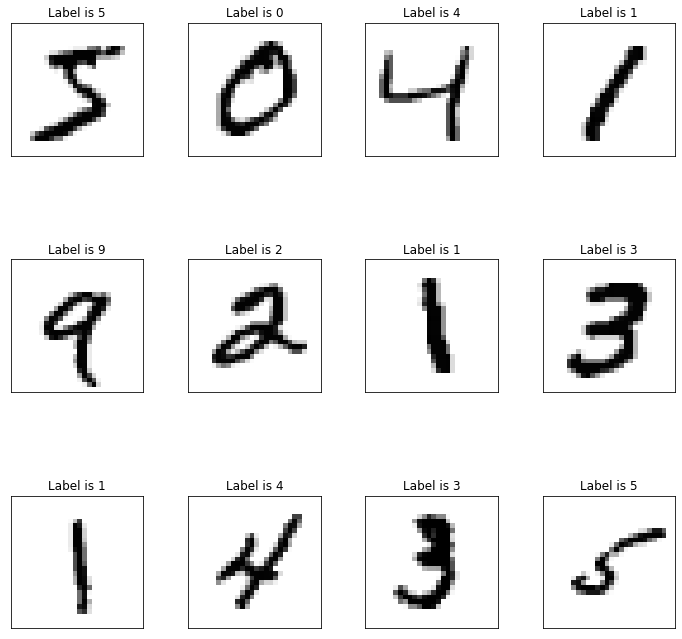

In [446]:
plot_slice(Y_train[0:12],X_train[0:12])#Raw Data

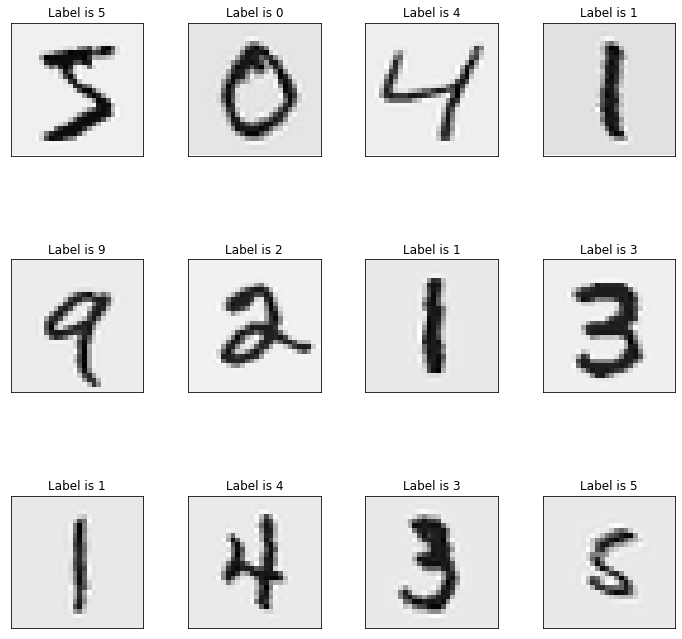

In [387]:
plot_slice(Y_train[0:12],X_train_deskew_df[0:12]*255) #Deskewed Raw Data

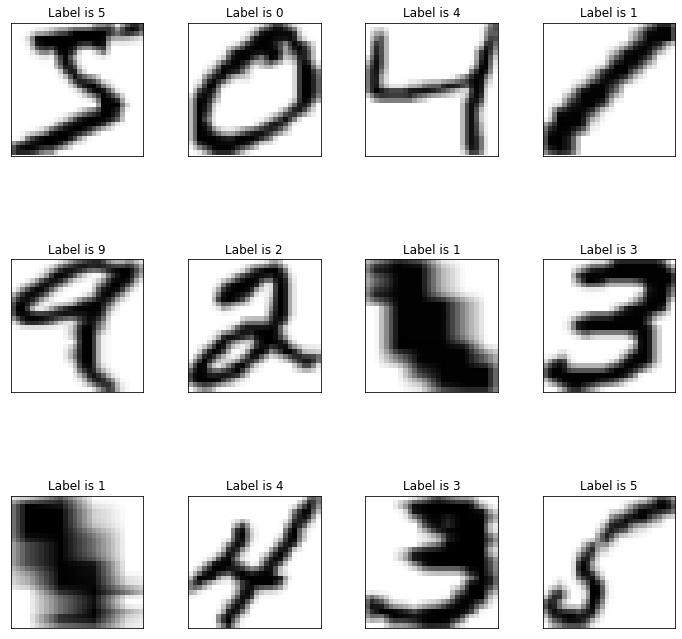

In [794]:
plot_slice(Y_train[0:12],X_train_enlarge[0:12]) #Enlarged Raw Data

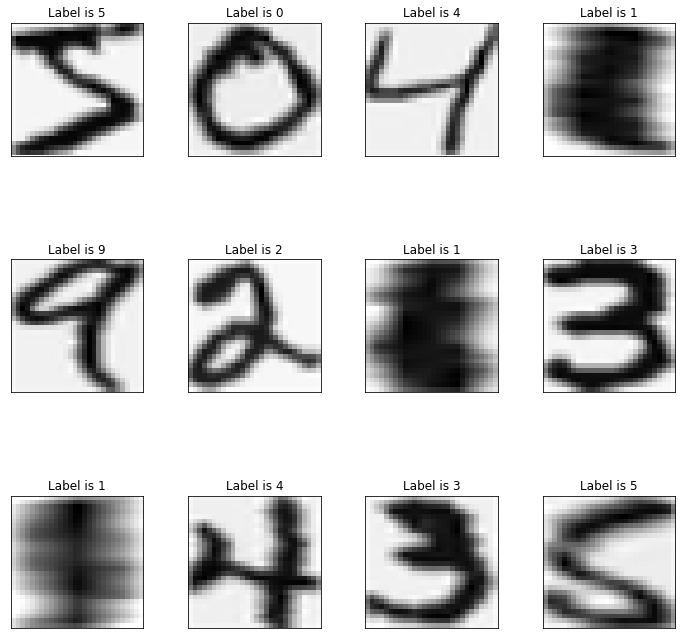

In [800]:
plot_slice(Y_train[0:12],X_train_deskew_enlarge[0:12]) #Enlarged Deskewed Raw Data

# **4.1 Plot single image**

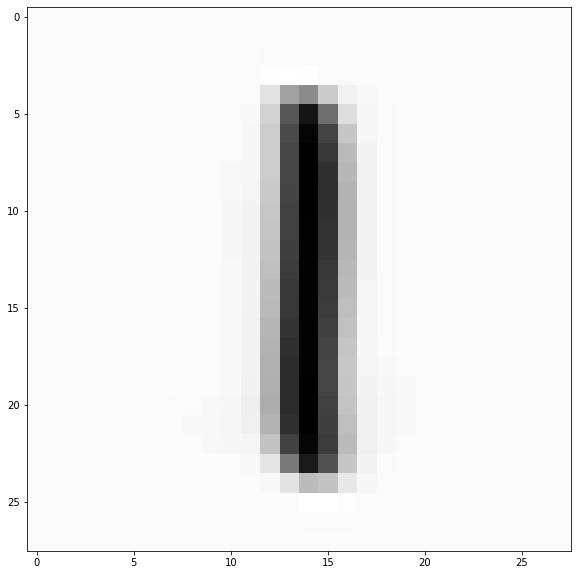

In [770]:
avgImg = np.zeros(784)
cnt = 0
for i in range(60000):
    if Y_train[i] == 1:
        avgImg = avgImg + 255*X_train_deskew_df.iloc[i]#X_train.iloc[i]#X_train_deskew_enlarge.iloc[i]#
        cnt = cnt + 1
avgImg = avgImg/cnt
#avgImg = avgImg.astype('uint8')
#print(avgImg)

avgImg = 255-np.array(avgImg, dtype='uint8')

# Reshape the array into 28 x 28 array (2-dimensional array)
avgImg = avgImg.reshape((28, 28))

# Plot
#plt.title('Label is {label}\n Predict is {pred}'.format(label=label,pred=pred))
plt.imshow(avgImg, cmap='gray')

# **Histogram**

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 <a list of 7 Text yticklabel objects>)

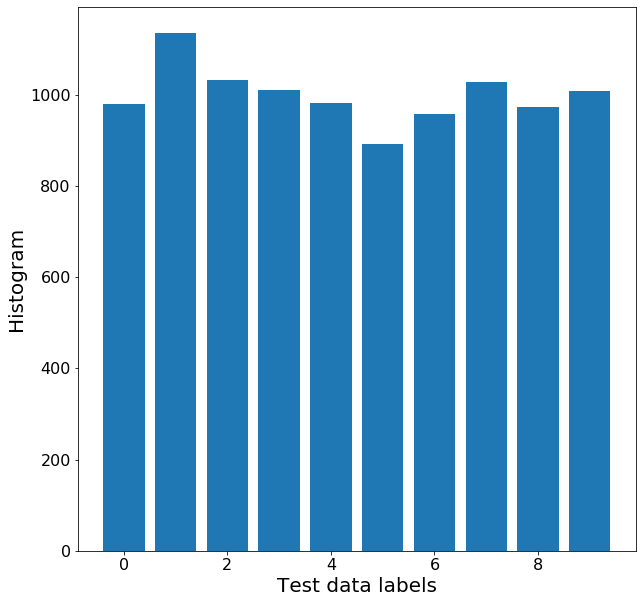

In [768]:
#hist_Y,labels = np.histogram(Y_train,bins=10)
#labels = range(10)
#plt.bar(labels,hist_Y)
plt.hist(Y_test,range=(0,10),align='left',rwidth=0.8)
plt.xlabel('Test data labels',fontsize=20)
plt.ylabel('Histogram',fontsize=20)
plt.xticks(size=16)
plt.yticks(size=16)

# **5. PCA**

# **5.1 PCA on Raw Data**

In [781]:
n_components = 784
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
pca = PCA(n_components=n_components, svd_solver='full',
          whiten=True).fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)

In [511]:
scaler = MinMaxScaler()
scaler.fit(X_test)
X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)

In [512]:
X_train_pca = pd.DataFrame(X_train_pca)
X_train_pca.columns = X_train_pca.columns+1

X_test_pca = pd.DataFrame(X_test_pca)
X_test_pca.columns = X_test_pca.columns+1

# **5.2 PCA on Deskewed Data**

In [660]:
n_components = 784
scaler = MinMaxScaler()
scaler.fit(X_train_deskew)
X_train_deskew_scaled = scaler.transform(X_train_deskew)
pca = PCA(n_components=n_components, svd_solver='full',
          whiten=True).fit(X_train_deskew_scaled)
X_train_deskew_pca = pca.transform(X_train_deskew_scaled)

In [295]:
scaler = MinMaxScaler()
scaler.fit(X_test_deskew)
X_test_deskew_scaled = scaler.transform(X_test_deskew)
X_test_deskew_pca = pca.transform(X_test_deskew_scaled)

In [296]:
X_train_deskew_pca = pd.DataFrame(X_train_deskew_pca)
X_train_deskew_pca.columns = X_train_deskew_pca.columns+1

X_test_deskew_pca = pd.DataFrame(X_test_deskew_pca)
X_test_deskew_pca.columns = X_test_deskew_pca.columns+1

# **5.3 PCA on Enlarged Data**

In [658]:
n_components = 784
scaler = MinMaxScaler()
scaler.fit(X_train_enlarge)
X_train_enlarge_scaled = scaler.transform(X_train_enlarge)
pca = PCA(n_components=n_components, svd_solver='full',
          whiten=True).fit(X_train_enlarge_scaled)
X_train_enlarge_pca = pca.transform(X_train_enlarge_scaled)

In [439]:
scaler = MinMaxScaler()
scaler.fit(X_test_enlarge)
X_test_enlarge_scaled = scaler.transform(X_test_enlarge)
X_test_enlarge_pca = pca.transform(X_test_enlarge_scaled)

In [440]:
X_train_enlarge_pca = pd.DataFrame(X_train_enlarge_pca)
X_train_enlarge_pca.columns = X_train_enlarge_pca.columns+1

X_test_enlarge_pca = pd.DataFrame(X_test_enlarge_pca)
X_test_enlarge_pca.columns = X_test_enlarge_pca.columns+1

# **5.4 PCA on Enlarged Deskewed Data**

In [889]:
n_components = 784
scaler = MinMaxScaler()
scaler.fit(X_train_deskew_enlarge)
X_train_deskew_enlarge_scaled = scaler.transform(X_train_deskew_enlarge)
pca = PCA(n_components=n_components, svd_solver='full',
          whiten=True).fit(X_train_deskew_enlarge_scaled)
X_train_deskew_enlarge_pca = pca.transform(X_train_deskew_enlarge_scaled)

In [890]:
scaler = MinMaxScaler()
scaler.fit(X_test_enlarge)
X_test_deskew_enlarge_scaled = scaler.transform(X_test_deskew_enlarge)
X_test_deskew_enlarge_pca = pca.transform(X_test_deskew_enlarge_scaled)

In [891]:
X_train_deskew_enlarge_pca = pd.DataFrame(X_train_deskew_enlarge_pca)
X_train_deskew_enlarge_pca.columns = X_train_deskew_enlarge_pca.columns+1

X_test_deskew_enlarge_pca = pd.DataFrame(X_test_deskew_enlarge_pca)
X_test_deskew_enlarge_pca.columns = X_test_deskew_enlarge_pca.columns+1

# **5.5 PCA visualization**

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


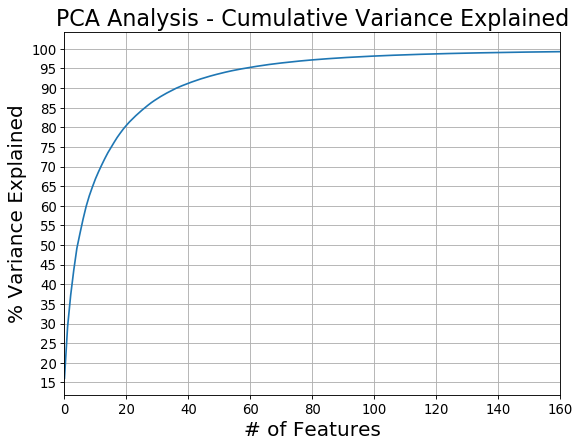

In [790]:
#n_components = 784
#pca = PCA(n_components=n_components)
#pca.fit(X_train_scaled)
#X_train_pca = pca.transform(X_train_scaled)
#print(pca.n_components_)

var=np.cumsum(pca.explained_variance_ratio_*100)

figure(num=None, figsize=(8, 6), dpi=80)

plt.ylabel('% Variance Explained',size=18)
plt.xlabel('# of Features',size=18)
plt.title('PCA Analysis - Cumulative Variance Explained',size = 20)
plt.xlim(0,160)
plt.xticks(size=12)
plt.yticks(np.arange(0, 110, step=5),size=12)
plt.style.context('seaborn-whitegrid')
ax = plt.axes()
ax.grid()
plt.plot(var);

# **6. Cross-validation to optimize parameters**

# **6.1 CV for PCA components on Raw Data (training)**

In [513]:
X_s1 = X_train_pca.iloc[0:20000]
X_s2 = X_train_pca.iloc[20000:40000]
X_s3 = X_train_pca.iloc[40000:60000]
Y_s1 = Y_train.iloc[0:20000]
Y_s2 = Y_train.iloc[20000:40000]
Y_s3 = Y_train.iloc[40000:60000]

In [514]:
lda = LDA(solver='svd',n_components=9,store_covariance=True)
scores = 0.0

train_data = pd.concat([X_s1,X_s2],axis=0)
train_label = pd.concat([Y_s1,Y_s2],axis=0)
lda.fit_transform(train_data,train_label)
scores = scores + lda.score(X_s3,Y_s3)/3

train_data = pd.concat([X_s1,X_s3],axis=0)
train_label = pd.concat([Y_s1,Y_s3],axis=0)
lda.fit_transform(train_data,train_label)
scores = scores + lda.score(X_s2,Y_s2)/3

train_data = pd.concat([X_s3,X_s2],axis=0)
train_label = pd.concat([Y_s3,Y_s2],axis=0)
lda.fit_transform(train_data,train_label)
scores = scores + lda.score(X_s1,Y_s1)/3

print(scores)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0.8625999999999999


# **6.2 CV for threshold on Resized Deskewed Data (training)**

In [796]:
X_s1 = X_train_deskew_enlarge.iloc[0:20000]
X_s2 = X_train_deskew_enlarge.iloc[20000:40000]
X_s3 = X_train_deskew_enlarge.iloc[40000:60000]
Y_s1 = Y_train.iloc[0:20000]
Y_s2 = Y_train.iloc[20000:40000]
Y_s3 = Y_train.iloc[40000:60000]

In [797]:
lda = LDA(solver='svd',n_components=9,store_covariance=True)
scores = 0.0

train_data = pd.concat([X_s1,X_s2],axis=0)
train_label = pd.concat([Y_s1,Y_s2],axis=0)
lda.fit_transform(train_data,train_label)
scores = scores + lda.score(X_s3,Y_s3)/3

train_data = pd.concat([X_s1,X_s3],axis=0)
train_label = pd.concat([Y_s1,Y_s3],axis=0)
lda.fit_transform(train_data,train_label)
scores = scores + lda.score(X_s2,Y_s2)/3

train_data = pd.concat([X_s3,X_s2],axis=0)
train_label = pd.concat([Y_s3,Y_s2],axis=0)
lda.fit_transform(train_data,train_label)
scores = scores + lda.score(X_s1,Y_s1)/3

print(scores)

0.9075


# **6.3 CV for PCA on Resized Deskewed Data (training)**

In [892]:
X_s1 = X_train_deskew_enlarge_pca.iloc[0:20000]
X_s2 = X_train_deskew_enlarge_pca.iloc[20000:40000]
X_s3 = X_train_deskew_enlarge_pca.iloc[40000:60000]
Y_s1 = Y_train.iloc[0:20000]
Y_s2 = Y_train.iloc[20000:40000]
Y_s3 = Y_train.iloc[40000:60000]

In [893]:
t0 = time()

lda = LDA(solver='svd',n_components=9,store_covariance=True)
scores = 0.0

train_data = pd.concat([X_s1,X_s2],axis=0)
train_label = pd.concat([Y_s1,Y_s2],axis=0)
lda.fit_transform(train_data,train_label)
scores = scores + lda.score(X_s3,Y_s3)/3

train_data = pd.concat([X_s1,X_s3],axis=0)
train_label = pd.concat([Y_s1,Y_s3],axis=0)
lda.fit_transform(train_data,train_label)
scores = scores + lda.score(X_s2,Y_s2)/3

train_data = pd.concat([X_s3,X_s2],axis=0)
train_label = pd.concat([Y_s3,Y_s2],axis=0)
lda.fit_transform(train_data,train_label)
scores = scores + lda.score(X_s1,Y_s1)/3

print("done in %0.3fs" % (time() - t0))
print(scores)

done in 20.478s
0.9254166666666666


# **6. LDA**

# **6.1 LDA on Raw Data**

In [82]:
lda = LDA(solver='svd',n_components=9,store_covariance=True)
lda.fit_transform(X_train,Y_train)
scores = lda.score(X_test,Y_test)
print(scores)
#Y_pred = lda.predict(X_test)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0.873


# **6.2 LDA on Deskewed Data**

In [83]:
lda = LDA(solver='svd',n_components=9,store_covariance=True)
lda.fit_transform(X_train_deskew_df,Y_train)
scores = lda.score(X_test_deskew_df,Y_test)
print(scores)
#Y_pred = lda.predict(X_test)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0.9173


# **6.3 LDA on Enlarged Data**

In [319]:
lda = LDA(solver='svd',n_components=9,store_covariance=True)
lda.fit_transform(X_train_enlarge,Y_train)
scores = lda.score(X_test_enlarge,Y_test)
print(scores)
#Y_pred = lda.predict(X_test)

0.9023


# **6.4 LDA on Enlarged Deskewed Data**

In [646]:
lda = LDA(solver='svd',n_components=9,store_covariance=True)
lda.fit_transform(X_train_deskew_enlarge,Y_train)
scores = lda.score(X_test_deskew_enlarge,Y_test)
print(scores)
Y_pred_deskew_enlarge = lda.predict(X_test_deskew_enlarge)

0.9291


# **7. LDA + PCA**

# **LDA+PCA on Raw Data**

In [84]:
t0 = time()
lda = LDA(solver='svd',n_components=9,store_covariance=True)
lda.fit_transform(X_train_pca,Y_train)
print("done in %0.3fs" % (time() - t0))
scores_pca = lda.score(X_test_pca,Y_test)
print(scores_pca)
Y_pred_pca = lda.predict(X_test_pca)

done in 0.859s
0.8765


# *LDA+PCA on Deskewed Data*

In [85]:
t0 = time()
lda = LDA(n_components=9,store_covariance=True)
lda.fit_transform(X_train_deskew_pca,Y_train)
print("done in %0.3fs" % (time() - t0))
scores_deskew_pca = lda.score(X_test_deskew_pca,Y_test)
print(scores_deskew_pca)
Y_pred_deskew_pca = lda.predict(X_test_deskew_pca)

done in 0.793s
0.9236


# **LDA+PCA on Enlarged Data**

In [444]:
t0 = time()
lda = LDA(solver='svd',n_components=9,store_covariance=True)
lda.fit_transform(X_train_enlarge_pca,Y_train)
print("done in %0.3fs" % (time() - t0))
scores_enlarge_pca = lda.score(X_test_enlarge_pca,Y_test)
print(scores_enlarge_pca)
Y_pred_enlarge_pca = lda.predict(X_test_enlarge_pca)

done in 0.707s
0.9024


# **LDA+PCA on Deskewed Enlarged Data**

In [647]:
t0 = time()
lda = LDA(n_components=9,store_covariance=True)
lda.fit_transform(X_train_deskew_enlarge_pca,Y_train)
print("done in %0.3fs" % (time() - t0))
scores_deskew_enlarge_pca = lda.score(X_test_deskew_enlarge_pca,Y_test)
print(scores_deskew_enlarge_pca)
Y_pred_deskew_enlarge_pca = lda.predict(X_test_deskew_enlarge_pca)

done in 0.698s
0.9224


# **Confusion Matrix**

In [242]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    #fig.tight_layout()
    #plt.grid(None) 
    plt.rcParams["figure.figsize"] = (10,10)
    return ax

Confusion matrix, without normalization
[[ 952    0    2    5    0    4   11    2    2    2]
 [   0 1076   15    7    2    3   10    1   19    2]
 [  19    1  924   24    5    1   10   13   34    1]
 [   8    0    6  953    2    9    0   13   14    5]
 [   0    0   13    0  912    0   13    0    8   36]
 [  19    0    2   28    9  816    3    0   12    3]
 [  15    1    5    0    7   14  911    0    5    0]
 [   0    0    6    7   21    2    0  933    9   50]
 [  11    0    7   29   19   21    3    6  862   16]
 [   4    2    4   15   38   13    0   20   20  893]]
Confusion matrix, LDA without deskewing without PCA
AxesSubplot(0.125,0.125;0.62x0.755)


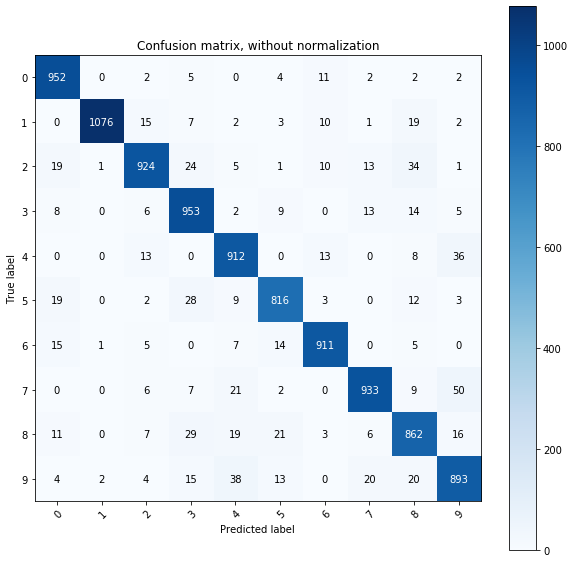

In [261]:
np.set_printoptions(precision=2)

titles_options = [("Confusion matrix, LDA without deskewing without PCA", None)]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(Y_test, Y_pred_deskew_enlarge, lda.classes_,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)

    print(title)
    print(disp)
    
plt.show();

# **Visualize Error Figure**

In [266]:
N = 230
Y_truth = Y_pred_deskew_enlarge[0:N]!=Y_test[0:N]
nErr = sum(Y_truth)
print("Number of Error in first %d test samples is %d"% (N,nErr))

Number of Error in first 230 test samples is 16


In [268]:
def plot_one(pred, label, pixels, w=28, h=28):
    #label = row['label']
    #pixels = row[1:]

    # Make those columns into a array of 8-bits pixels
    # This array will be of 1D with length 784
    # The pixel intensity values are integers from 0 to 255
    pixels = 255-np.array(pixels, dtype='uint8')

    # Reshape the array into 28 x 28 array (2-dimensional array)
    pixels = pixels.reshape((w, h))

    # Plot
    plt.title('Label is {label}\n Predict is {pred}'.format(label=label,pred=pred))
    plt.imshow(pixels, cmap='gray')


def plot_Err(pred, label, pixels, size_w=28, size_h=28):
    num = pixels.shape[0]
    w = 4
    h = math.ceil(num / w)
    fig, plots = plt.subplots(h, w)
    fig.tight_layout()

    for n in range(0, num):
        s = plt.subplot(h, w, n+1)
        s.set_xticks(())
        s.set_yticks(())
        plot_one(pred[n], label[n], pixels.loc[n], size_w, size_h)
    plt.show()

In [276]:
cnt = 0
numArray = list(range(N))
#print(numArray)
Y_pred_err = np.zeros(nErr)
Y_test_err = np.zeros(nErr)
X_test_err = np.zeros((nErr,784))
for i in numArray:
    #print(Y_truth[i])
    if Y_truth[i]==True:
        Y_pred_err[cnt] = Y_pred_deskew_enlarge[i]
        Y_test_err[cnt] = Y_test[i]
        #print(Y_test[i])
        X_test_err[cnt] = 255 - X_test_deskew_enlarge.iloc[i]
        cnt = cnt + 1

#Y_test_err = pd.DataFrame(Y_test_err)
#Y_test_err.columns = Y_test_err.columns + 1
X_test_err = pd.DataFrame(X_test_err)
X_test_err.columns = X_test_err.columns + 1

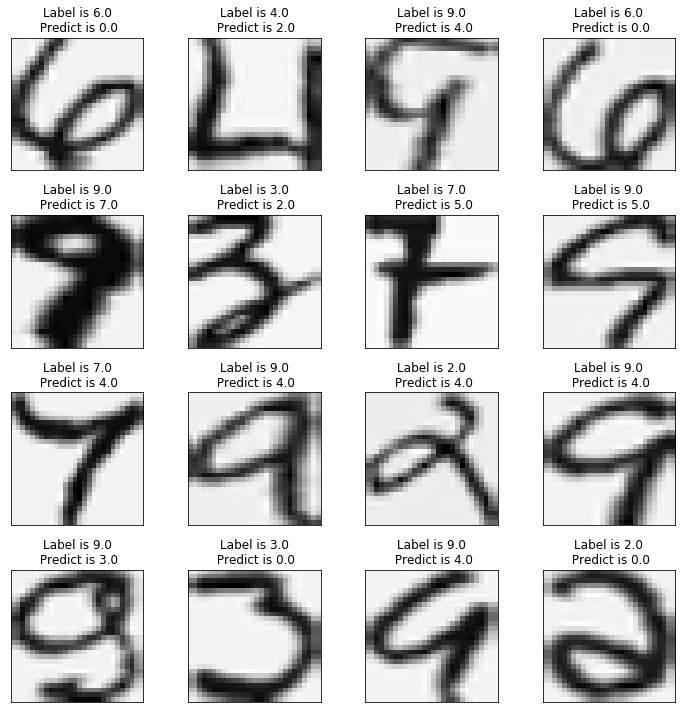

In [279]:
plot_Err(Y_pred_err,Y_test_err,X_test_err*255)